In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1443508334190890831,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214934385
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13554728908404948609
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import sys
import time
import math
import os
import pandas as pd
import numpy as np
from glob import glob
import skimage
from skimage.transform import resize

import keras
from keras import layers, models, optimizers, metrics
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Input, concatenate, Flatten, Dense
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,cohen_kappa_score
from sklearn.metrics import  confusion_matrix, classification_report, roc_auc_score, roc_curve,  log_loss
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.3.1
tensorflow Version 1.14.0


In [5]:
batch_size = 32
img_height, img_width = 600, 450
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("updated_data_modality/"))

['test', 'train']


In [7]:
train_dir = 'updated_data_modality/train/'
test_dir = 'updated_data_modality/test/'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 154 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 154
nb_validation_samples: 38
nb_test_samples: 82

predict_size_train: 5
predict_size_validation: 2
predict_size_test: 3

 num_classes: 2


In [11]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [13]:
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 

In [14]:
n = 10
test_accuracies = []
specificities = []
precisions = []
recalls = []
f1_scores = []
roc_auc_scores = []
no_errors = []
entries = []
descriptor_model_name = "Xception_descripter"

In [15]:
# --------------- Extract and Save Bottleneck Features --------------- #
bottleneck_final_model=Xception(weights="imagenet", include_top=False, pooling = "avg")

bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+descriptor_model_name+'.npy', bottleneck_features_train)

bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+descriptor_model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+descriptor_model_name+'.npy', bottleneck_features_test)

# --------------- Load Extracted Features --------------- #
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+descriptor_model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+descriptor_model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+descriptor_model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

******************************
38/38 [==============================] - 0s 105us/step
Validation Accuracy: 89.4737%
Validation Loss: 0.3470497915619298
Xception_run0_accuracy
Test Accuracy: 0.9512195121951219
[[38  3]
 [ 1 40]]
              precision    recall  f1-score   support

    COVID-19       0.97      0.93      0.95        41
      NORMAL       0.93      0.98      0.95        41

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Specificity :  0.9302325581395349
82/82 [==============================] - 0s 49us/step
Precision =  0.9522957662492547
Recall =  0.9512195121951219
f1_score =  0.9511904761904763
roc_auc_score =  0.951219512195122
Confusion Matrix
[[38  3]
 [ 1 40]]
******************************
******************************
38/38 [==============================] - 0s 79us/step
Validation Accuracy: 92.1053%
Validation Loss: 0.3202712818195945
Xception_run

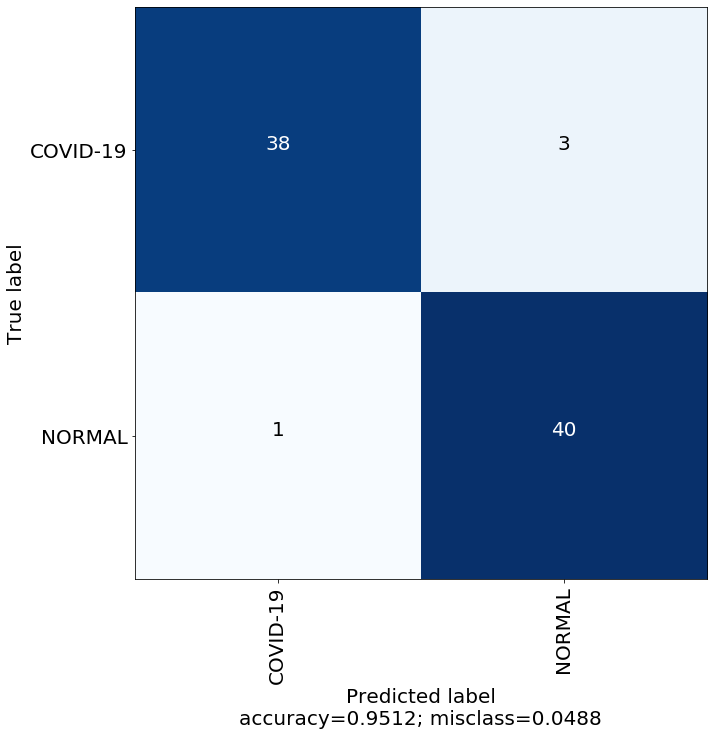

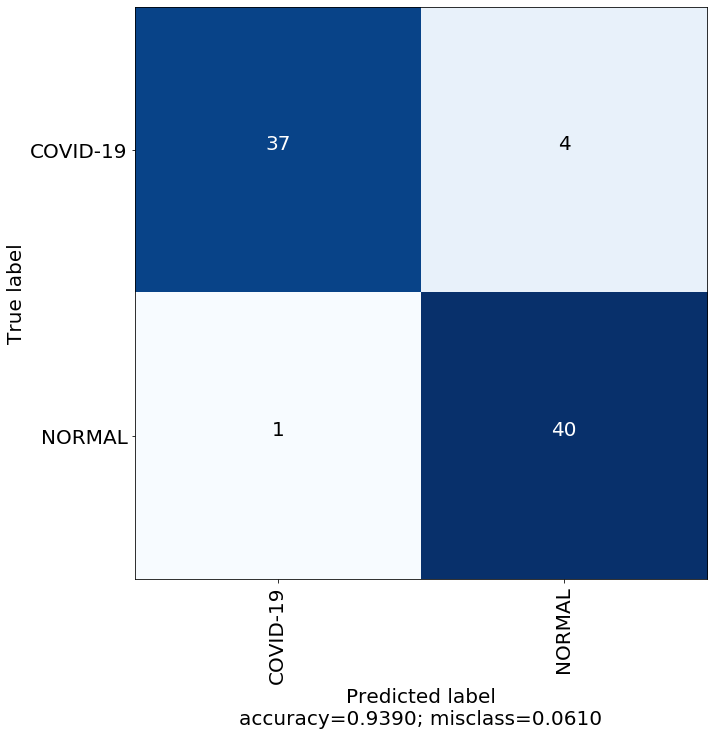

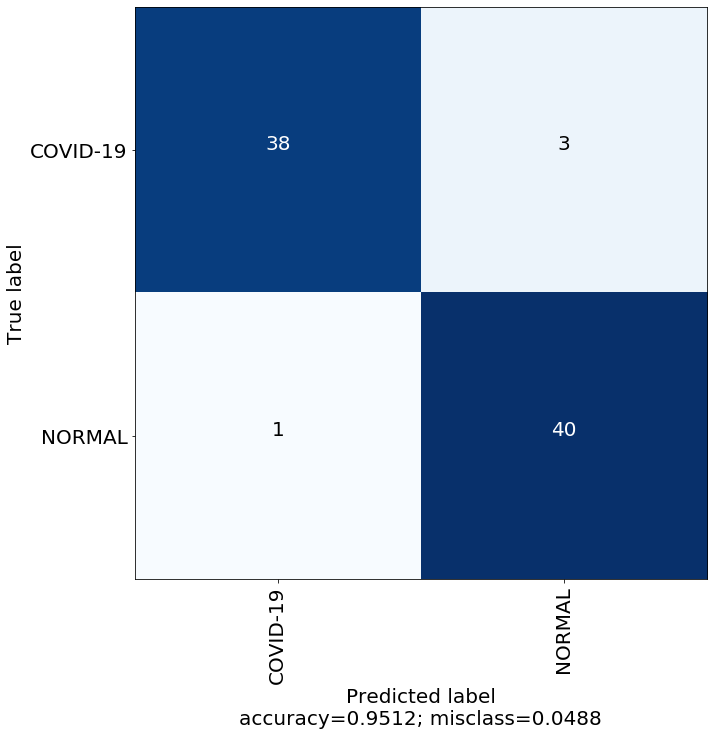

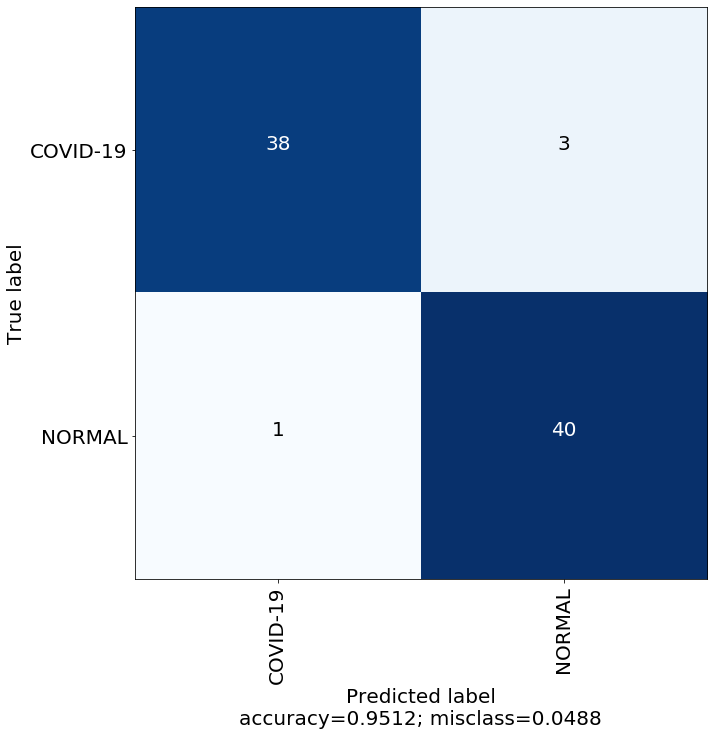

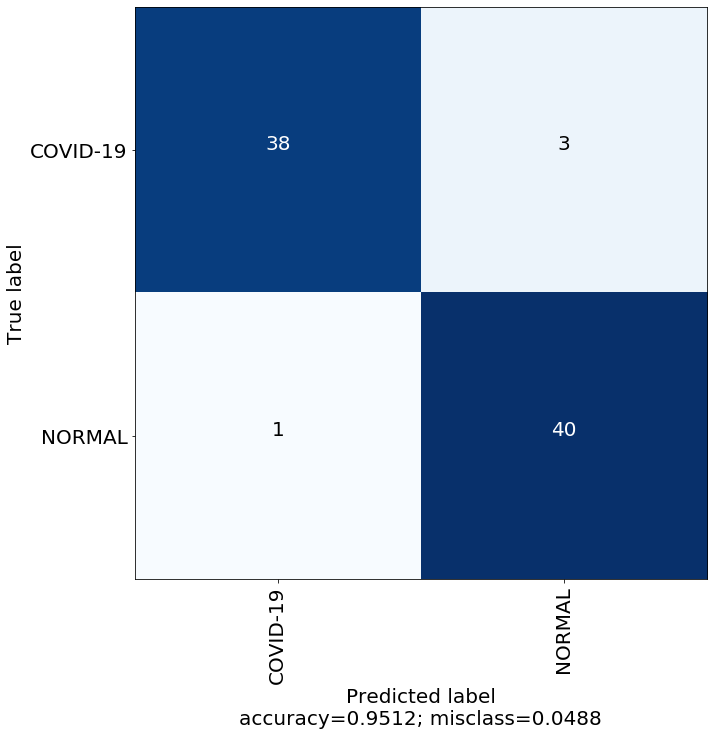

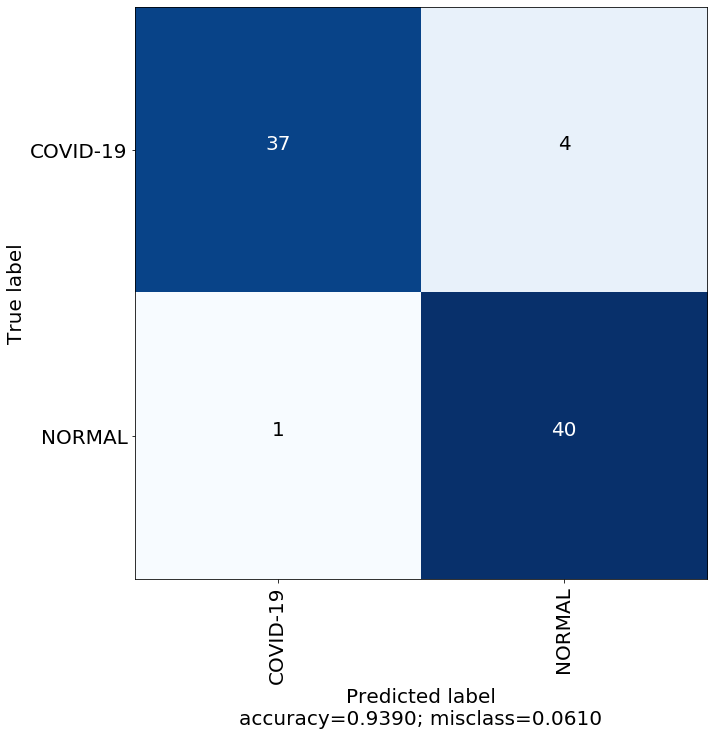

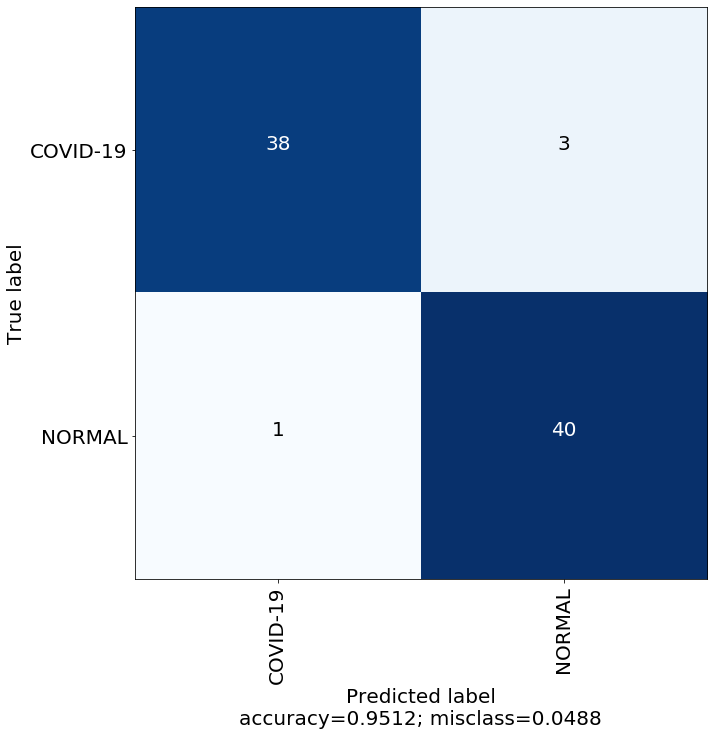

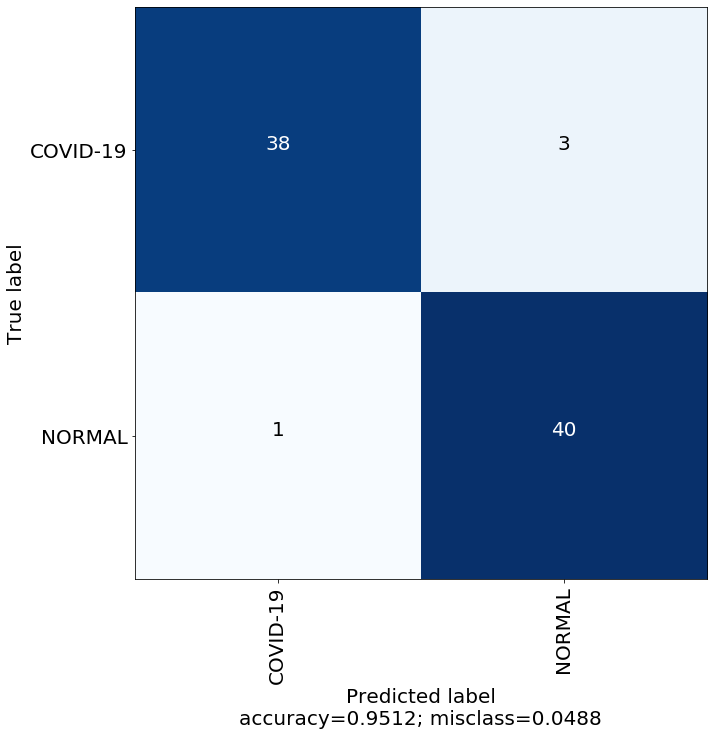

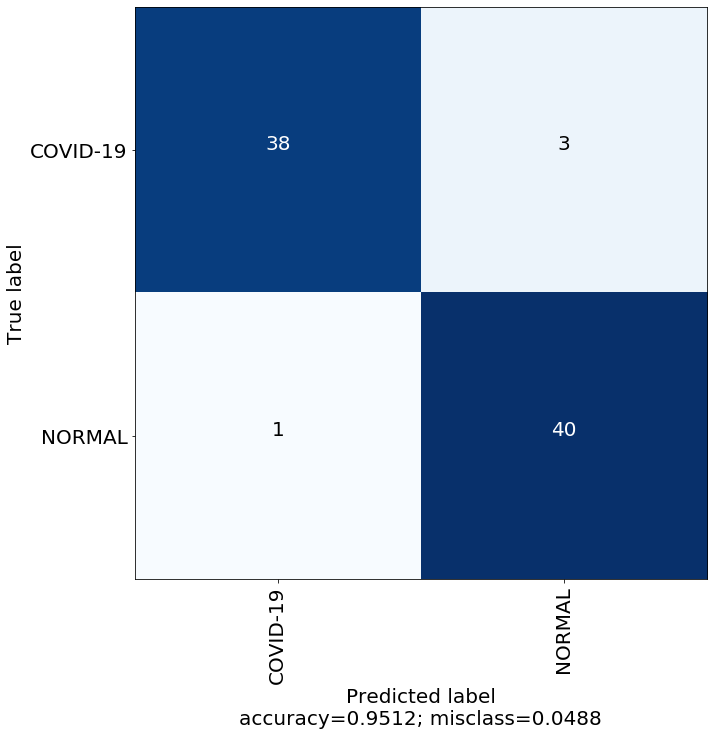

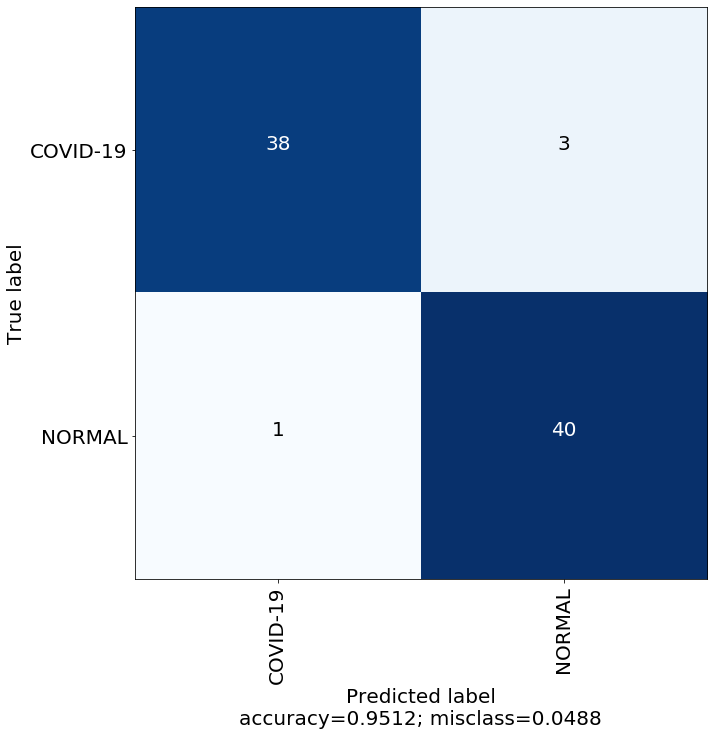

In [26]:
for i in range(n):
    print("*"*60)
    model_name = "Xception_run"+str(i)

 # --------------- Define Optimizer, model and compile the model --------------- #

    adam_opt=Adam(lr=1e-07, beta_1=0.9, beta_2=0.5)

    model = Sequential()
    model.add(Dense(2048, activation="selu", activity_regularizer=l1(1e-06)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

# --------------- Train the Model --------------- #

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels),
                        verbose= 0)

    (eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

    print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
    print("Validation Loss: {}".format(eval_loss))

# --------------- Test and Evaluate the Model --------------- #
    
    filename = test_generator.filenames
    truth = test_generator.classes
    label = test_generator.class_indices
    indexlabel = dict((value, key) for key, value in label.items())

    preds = model.predict(test_data)

    predictions = [i.argmax() for i in preds]
    y_true = [i.argmax() for i in test_labels]
    cm = confusion_matrix(y_pred=predictions, y_true=y_true)
    
    print(model_name+"_accuracy")
    print('Test Accuracy: {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))
    accuracy = accuracy_score(y_true=y_true, y_pred=predictions)
    test_accuracies.append(accuracy)

# --------------- Calculate Specificity, Precision, Recall, F1_Score, ROC_Score--------------- #

    y_pred=predictions
    y_pred_probabilities=y_pred

    # y_pred = np.argmax(y_pred,axis = 1) 
    y_actual = y_true

    classnames=[]
    for classname in test_generator.class_indices:
        classnames.append(classname)

    confusion_mtx = confusion_matrix(y_actual, y_pred) 
    print(confusion_mtx)
    target_names = classnames
    print(classification_report(y_actual, y_pred, target_names=target_names))

    total=sum(sum(cm))

    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    print('Specificity : ', specificity )
    specificities.append(specificity)
    
    y_pred_class = model.predict(test_data, verbose=1)

    y_pred_class = [np.argmax(r) for r in y_pred_class]
    test_y = [np.argmax(r) for r in test_labels]

    # Precision
    precision = precision_score(test_y, y_pred_class, average='weighted')
    print('Precision = ', precision)
    # (None, 'micro', 'macro', 'weighted', 'samples')
    precisions.append(precision)
    
    # Recall
    recall = recall_score(test_y, y_pred_class, average='weighted')
    print('Recall = ', recall)
    recalls.append(recall)
    
    # f1_score
    score_f1 = f1_score(test_y, y_pred_class, average='weighted')
    print('f1_score = ', score_f1)
    f1_scores.append(score_f1)
    
#     roc_auc_score
    score_roc = multiclass_roc_auc_score(test_y, y_pred_class)
    print('roc_auc_score = ', score_roc)
    roc_auc_scores.append(score_roc)
    
# # --------------- Number of Errors and Visualize them --------------- #
#     fnames = test_generator.filenames
#     ground_truth = test_generator.classes

#     label2index = test_generator.class_indices
#     idx2label = dict((v,k) for k,v in label2index.items())

#     predictions = model.predict(test_data)
#     predicted_classes = np.argmax(predictions,axis=1)

#     errors = np.where(predicted_classes != ground_truth)[0]
#     no_error = len(errors)
#     print("No of errors = {}/{}".format(len(errors),test_generator.samples))
#     no_errors.append(no_error)

#     # Show the errors
#     for i in range(len(errors)):
#         pred_class = np.argmax(predictions[errors[i]])
#         pred_label = idx2label[pred_class]

#         title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
#             fnames[errors[i]].split('/')[0],
#             pred_label,
#             predictions[errors[i]][pred_class], pred_class)

#         original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
#         plt.figure(figsize=[7,7])
#         plt.axis('off')
#         plt.title(title)
#         plt.imshow(original)
#     plt.show()

# --------------- Save the Model and Trained Weights --------------- #

    # model.save('extracted_features/xception_modified_model.h5')
    # model.save_weights('extracted_features/xception_modified_weights.h5')
    
# --------------- Confusion Matrix  --------------- #    
    plt.rcParams["axes.grid"] = False
    plt.rcParams.update({'font.size': 20})

    labels = []

    label = test_generator.class_indices
    indexlabel = dict((value, key) for key, value in label.items())

    for k,v in indexlabel.items():
        labels.append(v)
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=labels, title=' ')

##################################################################
    entries.append((model_name, accuracy, specificity, precision, recall, score_f1, score_roc))
    print("*"*60)

In [27]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy',  'specificity', 'precision', 
                                       'recall', 'f1_score', 'roc_auc_score'])

In [28]:
# cv_df.to_csv("results.csv", index=False)
# cv_df

In [29]:
print("*"*10, " Mean of metrics", "*"*10)
cv_df.drop('model_name', axis=1).apply(lambda x: x.mean(), axis=0)

**********  Mean of metrics **********


accuracy         0.950000
specificity      0.929243
precision        0.951173
recall           0.950000
f1_score         0.949965
roc_auc_score    0.950000
dtype: float64

In [30]:
print("*"*10, " STD of metrics", "*"*10)
cv_df.drop('model_name', axis=1).apply(lambda x: x.std(), axis=0)

**********  STD of metrics **********


accuracy         0.007814
specificity      0.013064
precision        0.007289
recall           0.007814
f1_score         0.007834
roc_auc_score    0.007814
dtype: float64

# Machine Learning Algorithms

In [ ]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score


k_fold = KFold(n_splits=10, shuffle=True, random_state=5)

In [ ]:
y_test = np.asarray(test_labels)
y_test = np.argmax(y_test, axis=1)

y_train = np.asarray(train_labels)
y_train = np.argmax(y_train, axis=1)

## Bagging Classifier

In [ ]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('Bagging Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))

In [ ]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("BaggingClassifier - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## AdaBoost Classifier

In [ ]:
clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(AdaBoost Classifier) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## XGBoost Classifier

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('XGB Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("XGB - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Decision Tree Classifier

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('DecisionTree Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("DecisionTree - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('RandomForest Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, test_labels, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(RandomForest) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Light GBM

In [ ]:
import lightgbm as lgb

lgbm=lgb.LGBMClassifier(n_estimators=1000, class_weight="balanced", reg_alpha=0.1, reg_lambda=0.1, learning_rate=0.001, num_leaves=400,
                        random_state=523, boosting='dart')

lgbm_scores=cross_val_score(lgbm,train_data, y_train, cv=10)
print(lgbm_scores)
print("Train accuracy mean and std %.2f" %np.mean(lgbm_scores),"+/- %.2f"%np.std(lgbm_scores))

In [ ]:
lgbm.fit(train_data, y_train)
y_pred=lgbm.predict(test_data)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(lgbm, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(LighGBM) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.figure(figsize=(20,8))
N = epochs
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="center right")

In [ ]:
plt.figure(figsize=(20,8))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="center right")

In [ ]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

In [ ]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})
lw=2

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()